This notebook uses an extract from the dataset for a single point in time to build a static GNN model (without historical data). No features are used (x corresponds to a dummy), so that the model can learn to estimate the price (at the same point in time t) solely through the graph structure and learning per node.This model is suitable for testing the structure of the graph (e.g. definition of edges).

# 1. Import Data

In [1]:
# Standard libs
from __future__ import annotations
from dataclasses import dataclass
import os
import glob
import json

# Utils
import math
import random
import gc

# Data & Processing
import numpy as np
import pandas as pd
import geopandas as gpd

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.neighbors import BallTree, NearestNeighbors
from sklearn.model_selection import train_test_split

# TQDM
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch_geometric.utils import subgraph

# PyTorch Geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv


# Confirm the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/qusta100/STGNN


In [2]:
#Load data
df = pd.read_csv(
    "/gpfs/scratch/qusta100/STGNN/Data/Temp/final.csv",
    dtype={9: str}
)

#Filter for one specific day and time
df = df[df['date'].str.startswith("2025-04-01 11:00")]
df.head()

,date,station_uuid,diesel,e5,e10,uuid,name,brand,street,house_number,...,openingtimes_json,day,in_thuringia,in_region,last_seen,is_open,weekday,holiday,time,Brent_Price
44,2025-04-01 11:00:00,00060065-7890-4444-8888-acdc00000004,1.569,1.729,1.669,00060065-7890-4444-8888-acdc00000004,Georg Ultsch GmbH,Tankstelle Lichtenfels,Robert-Koch-Str.,18,...,{},2025-04-30,False,1,2025-04-30 21:45:00,True,Tuesday,0,11:00,74.849998
2916,2025-04-01 11:00:00,00060072-0001-4444-8888-acdcffffffff,1.519,1.669,1.619,00060072-0001-4444-8888-acdcffffffff,Tankstelle Schwarzenbach/Saale,Sigmund Hoffmann,Industriestrasse,11,...,{},2025-04-30,False,1,2025-04-30 21:45:00,True,Tuesday,0,11:00,74.849998
5788,2025-04-01 11:00:00,00060073-0002-4444-8888-acdcffffffff,1.519,1.669,1.619,00060073-0002-4444-8888-acdcffffffff,Tankstelle Hof/Saale,Sigmund Hoffmann,Am Gueterbahnhof,12,...,{},2025-04-30,False,1,2025-04-30 21:45:00,True,Tuesday,0,11:00,74.849998
8660,2025-04-01 11:00:00,00060075-0001-4444-8888-acdc00000001,1.639,1.789,1.729,00060075-0001-4444-8888-acdc00000001,1A Tank,NaN,Schlegelstr.,13,...,{},2025-04-30,True,1,2025-04-30 21:45:00,True,Tuesday,0,11:00,74.849998
11532,2025-04-01 11:00:00,00060146-0001-4444-8888-acdc00000001,1.809,1.799,1.739,00060146-0001-4444-8888-acdc00000001,Auto-Service Schleiz GmbH,Auto-Service Schleiz GmbH,Oschitzer Str.,80,...,{},2025-04-30,True,1,2025-04-30 21:45:00,True,Tuesday,0,11:00,74.849998


## 2. GNN Model

For this GNN model, I am using approach 1 (see below) as an example.

In [3]:
# =============================
# a) Parameter
# =============================

STATION_COL = "station_uuid"
LAT_COL = "latitude"
LON_COL = "longitude"
TARGET_COL = "e5"

RADIUS_KM = 10.0
NEIGHBOUR = 5 #not necessary for thsi approach

EMBED_DIM = 32
HIDDEN_DIM = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 400
PATIENCE = 30
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
SEED = 42

# =============================
# b) Auxiliary Functions
# =============================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def km_to_radians(km: float) -> float:
    earth_radius_km = 6371.0088
    return km / earth_radius_km


def build_radius_graph(lat_lon_deg: np.ndarray, radius_km: float) -> np.ndarray:
    lat_lon_rad = np.radians(lat_lon_deg)
    tree = BallTree(lat_lon_rad, metric="haversine")
    rad = km_to_radians(radius_km)

    ind = tree.query_radius(lat_lon_rad, r=rad, return_distance=False)

    src, dst = [], []
    for i, neigh in enumerate(ind):
        for j in neigh:
            if i == j:
                continue
            src.append(j)
            dst.append(i)
    edge_index = np.vstack([np.array(src), np.array(dst)])
    return edge_index


def make_data_from_df(df: pd.DataFrame) -> tuple[Data, pd.DataFrame]:
    assert all(col in df.columns for col in [STATION_COL, LAT_COL, LON_COL, TARGET_COL]), (
        f"Expected columns are missing. Found: {df.columns.tolist()}"
    )

    stations = df[[STATION_COL, LAT_COL, LON_COL]].drop_duplicates().reset_index(drop=True)
    stations["node_id"] = np.arange(len(stations))

    # Edges over 5-km-Radius
    lat_lon = stations[[LAT_COL, LON_COL]].to_numpy(dtype=float)
    edge_index_np = build_radius_graph(lat_lon, RADIUS_KM)

    # Labels: If there are multiple lines per station, take the average value (one timestamp -> doesn't matter)
    # QS: in this case I do only have one time stamp (no difference)
    target = df.groupby(STATION_COL, as_index=False)[TARGET_COL].mean() 

    # Join: Map labels to node_ids
    snap = stations[[STATION_COL, "node_id"]].merge(target, on=STATION_COL, how="left")

    y = torch.full((len(stations), 1), float("nan"))
    mask_have = ~snap[TARGET_COL].isna()
    y_vals = snap.loc[mask_have, TARGET_COL].astype(float).to_numpy()
    node_ids = snap.loc[mask_have, "node_id"].astype(int).to_numpy()
    y[node_ids, 0] = torch.tensor(y_vals, dtype=torch.float32)

    # No external features: dummy input + learnable embeddings in the model
    x = torch.ones((len(stations), 1), dtype=torch.float32)

    data = Data(
        x=x,
        edge_index=torch.tensor(edge_index_np, dtype=torch.long),
        y=y.squeeze(-1) #because vector is expected
    )

    # Split only via nodes with valid labels
    mask_th = df[[STATION_COL, "in_thuringia"]].drop_duplicates().set_index(STATION_COL)["in_thuringia"]
    snap = snap.join(mask_th, on=STATION_COL)
    avail_nodes = snap.loc[snap["in_thuringia"] == 1, "node_id"].to_numpy()

    train_nodes, temp_nodes = train_test_split(avail_nodes, test_size=VAL_SPLIT + TEST_SPLIT, random_state=SEED)
    rel = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)
    val_nodes, test_nodes = train_test_split(temp_nodes, test_size=rel, random_state=SEED)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.test_mask  = torch.zeros(data.num_nodes, dtype=torch.bool) # all false

    data.train_mask[torch.tensor(train_nodes)] = True
    data.val_mask[torch.tensor(val_nodes)] = True
    data.test_mask[torch.tensor(test_nodes)] = True

    meta = stations[[STATION_COL, LAT_COL, LON_COL, "node_id"]].copy()
    return data, meta

# =============================
# c) Model
# =============================
class GNNRegressor(nn.Module):
    def __init__(self, num_nodes: int, embed_dim: int, hidden_dim: int):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, embed_dim)
        self.proj = nn.Linear(1 + embed_dim, hidden_dim)  # 1 kommt von Dummy-x
        self.conv1 = SAGEConv(hidden_dim, hidden_dim)
        self.act = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, data: Data):
        h = torch.cat([data.x, self.emb.weight], dim=1)
        h = self.proj(h)
        h = self.act(h)
        h = self.conv1(h, data.edge_index)
        h = self.act(h)
        h = self.conv2(h, data.edge_index)
        h = self.act(h)
        out = self.head(h).squeeze(-1)
        return out

# =============================
# d) Training & Evaluation
# =============================
@dataclass
class TrainConfig:
    lr: float = LR
    weight_decay: float = WEIGHT_DECAY
    epochs: int = EPOCHS
    patience: int = PATIENCE


def train_model(data: Data, cfg: TrainConfig) -> dict:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GNNRegressor(num_nodes=data.num_nodes, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM).to(device)
    data = data.to(device)

    opt = AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    loss_fn = nn.SmoothL1Loss()

    best_state = None
    best_val = float("inf")
    wait = 0

    for epoch in range(cfg.epochs):
        model.train()
        opt.zero_grad()
        pred = model(data)

        train_mask = data.train_mask & torch.isfinite(data.y)
        loss = loss_fn(pred[train_mask], data.y[train_mask])
        loss.backward()
        opt.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_mask = data.val_mask & torch.isfinite(data.y)
            val_pred = pred[val_mask]
            val_true = data.y[val_mask]
            val_mae = torch.mean(torch.abs(val_pred - val_true)).item() if val_pred.numel() > 0 else float("nan")

        if val_mae < best_val:
            best_val = val_mae
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= cfg.patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # Test-Metrics
    model.eval()
    with torch.no_grad():
        pred = model(data)
        def metrics(mask):
            mask = mask & torch.isfinite(data.y)
            p = pred[mask]
            t = data.y[mask]
            mae = torch.mean(torch.abs(p - t)).item() if p.numel() > 0 else float("nan")
            mse = torch.mean((p - t) ** 2).item() if p.numel() > 0 else float("nan")
            rmse = math.sqrt(mse) if math.isfinite(mse) else float("nan")
            return {"MAE": mae, "RMSE": rmse}
        out = {
            "val": metrics(data.val_mask),
            "test": metrics(data.test_mask),
            "pred": pred.detach().cpu().numpy(),
        }
    return {"model": model, "metrics": out}

# =============================
# e) High-Level API: train_gnn(df)
# =============================

def train_gnn(df: pd.DataFrame, *, seed: int = SEED) -> dict:
    set_seed(seed)
    data, meta = make_data_from_df(df)
    cfg = TrainConfig()
    result = train_model(data, cfg)

    pred = result["metrics"]["pred"]
    pred_df = meta.copy()
    pred_df["pred_E5"] = pred
    return {
        "model": result["model"],
        "metrics": {k: v for k, v in result["metrics"].items() if k in ("val", "test")},
        "pred_df": pred_df,
    }

In [4]:
# Prediction
result = train_gnn(df)

print("Val:", result["metrics"]["val"])
print("Test:", result["metrics"]["test"])

pred = result["pred_df"]
pred.head()

Val: {'MAE': 0.06943602114915848, 'RMSE': 0.08796352171479334}
Test: {'MAE': 0.06550406664609909, 'RMSE': 0.08541152122553088}


,station_uuid,latitude,longitude,node_id,pred_E5
0,00060065-7890-4444-8888-acdc00000004,50.139297,11.076007,0,1.744626
1,00060072-0001-4444-8888-acdcffffffff,50.225151,11.946440,1,1.823489
2,00060073-0002-4444-8888-acdcffffffff,50.308479,11.916880,2,1.820494
3,00060075-0001-4444-8888-acdc00000001,50.930889,10.717990,3,1.758388
4,00060146-0001-4444-8888-acdc00000001,50.571877,11.808653,4,1.764826


# 3. Testing different graph definitions

The code above must be executed first, as it contains the required definitions for the following cells. The first approach corresponds to the approach already mentioned above.

In [119]:
# Defining function to evaluate the different approaches later.

def _edge_dist_stats_incoming(edge_index: np.ndarray, dists_km: np.ndarray):
    if edge_index is None or dists_km is None:
        return {"min_km": None, "max_km": None, "mean_km": None}

    if edge_index.size == 0 or dists_km.size == 0:
        return {"min_km": None, "max_km": None, "mean_km": None}

    # edge_index: shape (2, E)
    src, dst = edge_index  # src wird hier nicht benutzt, der Vollständigkeit halber

    if dists_km.size != dst.size:
        raise ValueError("dists_km und edge_index haben unterschiedliche Anzahl Kanten")

    # Anzahl Knoten (angenommen 0-basierte Indizes)
    num_nodes = int(dst.max()) + 1

    # Summe der Distanzen und Anzahl der eingehenden Kanten je Node
    sum_dists_in = np.bincount(dst, weights=dists_km, minlength=num_nodes)
    counts_in = np.bincount(dst, minlength=num_nodes)

    # Nur Nodes mit mindestens einer eingehenden Kante
    valid = counts_in > 0
    if not np.any(valid):
        return {"min_km": None, "max_km": None, "mean_km": None}

    means_nodes = sum_dists_in[valid] / counts_in[valid]

    return {
        "min_km": round(float(np.min(means_nodes)), 3),
        "max_km": round(float(np.max(means_nodes)), 3),
        "mean_km": round(float(np.mean(means_nodes)), 3),
        "n_nodes_with_incoming": int(valid.sum()),  # optional
    }


def region_graph_metrics(
    df,
    meta,
    data,
    *,
    id_col="station_uuid",
    region_col="in_thuringia"
):
    # Merge region flag into meta
    region_map = df[[id_col, region_col]].drop_duplicates(id_col)
    meta2 = meta.merge(region_map, on=id_col, how="left", validate="1:1")

    th_mask = torch.as_tensor(meta2[region_col].to_numpy(), dtype=torch.bool)
    ei = data.edge_index
    N = data.num_nodes

    # Mask edges inside region
    edge_mask_reg = th_mask[ei[1]]
    ei_reg = ei[:, edge_mask_reg]
    N_reg = int(th_mask.sum())
 
    deg = torch.bincount(ei_reg[1], minlength=N)
    avg_degree = round(float(deg[th_mask].float().mean().item()), 2)

    connected = torch.zeros(N, dtype=torch.bool)
    if ei_reg.numel() > 0:
        connected[ei_reg[1]] = True   # only ingoing edges
    num_isolated = int((~connected & th_mask).sum().item())

    ei_np = ei_reg.detach().cpu().numpy()
    mask_uniq = ei_np[0] < ei_np[1]
    src_u, dst_u = ei_np[0][mask_uniq], ei_np[1][mask_uniq]
    

    return {
        "avg_degree": avg_degree,
        "num_isolated": num_isolated,
        "edge_index_region": ei_reg,
        "unique_edges_src": src_u,
        "unique_edges_dst": dst_u,
        "node_mask_region": th_mask,
        "num_nodes_region": N_reg,
    }

# Filter metrics only for Thuringia
stations = df.loc[df["in_thuringia"], [LAT_COL, LON_COL]].drop_duplicates().to_numpy(dtype=float)

## 3.1. Approach 1 (Radius)

In [32]:
# =============================
# a) Updated Parameter
# =============================

RADIUS_KM = 8.0

# =============================
# b) Updated Auxilary Functions
# =============================

def build_radius_graph(lat_lon_deg: np.ndarray, radius_km: float, return_dists: bool = False):
    lat_lon_rad = np.radians(lat_lon_deg)
    tree = BallTree(lat_lon_rad, metric="haversine")
    rad = km_to_radians(radius_km)

    ind_list, dist_list = tree.query_radius(lat_lon_rad, r=rad, return_distance=True)

    src, dst, dists = [], [], []
    for i, (neigh, dist_rad) in enumerate(zip(ind_list, dist_list)):
        for j, dij in zip(neigh, dist_rad):
            if i == j:
                continue
            src.append(j)
            dst.append(i)
            dists.append(dij)

    edge_index = np.vstack([np.array(src), np.array(dst)])

    if return_dists:
        dists_km = np.array(dists) * 6371.0088
        return edge_index, dists_km

    return edge_index


def make_data_from_df(df: pd.DataFrame) -> tuple[Data, pd.DataFrame]:
    assert all(col in df.columns for col in [STATION_COL, LAT_COL, LON_COL, TARGET_COL]), (
        f"Expected columns are missing. Found: {df.columns.tolist()}"
    )

    stations = df[[STATION_COL, LAT_COL, LON_COL]].drop_duplicates().reset_index(drop=True)
    stations["node_id"] = np.arange(len(stations))

    # Edges over 5-km-Radius
    lat_lon = stations[[LAT_COL, LON_COL]].to_numpy(dtype=float)
    edge_index_np = build_radius_graph(lat_lon, RADIUS_KM)

    # Labels: If there are multiple lines per station, take the average value (one timestamp -> doesn't matter)
    # QS: in this case I do only have one time stamp (no difference)
    target = df.groupby(STATION_COL, as_index=False)[TARGET_COL].mean() 

    # Join: Map labels to node_ids
    snap = stations[[STATION_COL, "node_id"]].merge(target, on=STATION_COL, how="left")

    y = torch.full((len(stations), 1), float("nan"))
    mask_have = ~snap[TARGET_COL].isna()
    y_vals = snap.loc[mask_have, TARGET_COL].astype(float).to_numpy()
    node_ids = snap.loc[mask_have, "node_id"].astype(int).to_numpy()
    y[node_ids, 0] = torch.tensor(y_vals, dtype=torch.float32)

    # No external features: dummy input + learnable embeddings in the model
    x = torch.ones((len(stations), 1), dtype=torch.float32)

    data = Data(
        x=x,
        edge_index=torch.tensor(edge_index_np, dtype=torch.long),
        y=y.squeeze(-1) #because vector is expected
    )

    # Split only via nodes with valid labels
    mask_th = df[[STATION_COL, "in_thuringia"]].drop_duplicates().set_index(STATION_COL)["in_thuringia"]
    snap = snap.join(mask_th, on=STATION_COL)
    avail_nodes = snap.loc[snap["in_thuringia"] == 1, "node_id"].to_numpy()

    train_nodes, temp_nodes = train_test_split(avail_nodes, test_size=VAL_SPLIT + TEST_SPLIT, random_state=SEED)
    rel = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)
    val_nodes, test_nodes = train_test_split(temp_nodes, test_size=rel, random_state=SEED)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.test_mask  = torch.zeros(data.num_nodes, dtype=torch.bool) # all false

    data.train_mask[torch.tensor(train_nodes)] = True
    data.val_mask[torch.tensor(val_nodes)] = True
    data.test_mask[torch.tensor(test_nodes)] = True

    meta = stations[[STATION_COL, LAT_COL, LON_COL, "node_id"]].copy()
    return data, meta

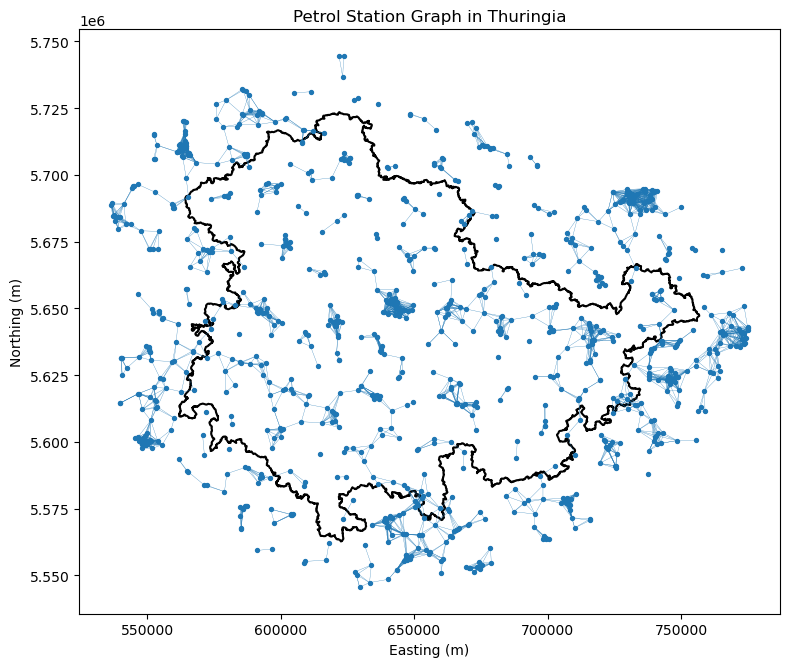

In [33]:
# Base data
data, meta = make_data_from_df(df)
coords = meta[[LAT_COL, LON_COL]].to_numpy(dtype=float)
edge_index = data.edge_index.detach().cpu().numpy()
mask_uniq = edge_index[0] < edge_index[1]
src, dst = edge_index[0][mask_uniq], edge_index[1][mask_uniq]

# GeoFrames: project Thuringia boundaries
gdf = gpd.read_file("/gpfs/scratch/qusta100/STGNN/Data/Shapes/thuringia.geojson").to_crs(epsg=25832)

# Points as GeoDataFrame
points_wgs84 = gpd.GeoSeries(gpd.points_from_xy(coords[:,1], coords[:,0]), crs=4326)
points = points_wgs84.to_crs(epsg=25832)

# Edges as LineStrings
from shapely.geometry import LineString
lines = gpd.GeoSeries(
    [LineString([points.iloc[i], points.iloc[j]]) for i, j in zip(src, dst)],
    crs=25832
)

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, linewidth=1.5, edgecolor="black", facecolor="none")
lines.plot(ax=ax, linewidth=0.2)
points.plot(ax=ax, markersize=8)

ax.set_title("Petrol Station Graph in Thuringia")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [34]:
# Calculating metrices

# 1. Number of Edges and Isolated Stations
res = region_graph_metrics(df, meta, data) 
print("Average Degree:", res["avg_degree"])
print("isolated Stations:", res["num_isolated"])

# 2. Min/Max/Mean of Neighbours
def edge_distance_stats_radius(lat_lon_deg: np.ndarray, radius_km: float):
    edge_index, dists_km = build_radius_graph(
        lat_lon_deg, radius_km=radius_km, return_dists=True
    )
    return _edge_dist_stats(edge_index, dists_km)

stats1 = edge_distance_stats_radius(stations, radius_km=RADIUS_KM)
print(stats1)
print("Note: Always bidirectional edges.")

Average Degree: 7.53
isolated Stations: 5
{'min_km': 0.116, 'max_km': 7.99, 'mean_km': 4.317, 'n_nodes_with_edges': 389}
Note: Always bidirectional edges.


## 3.2 Approach 2 (Adaptive Radius) 

In [169]:
# =============================
# a) Updated Parameter
# =============================

NEIGHBOUR = 4
ALPHA = 1.2


# =============================
# b) Updated Auxilary Functions
# =============================

def build_radius_graph(lat_lon_deg: np.ndarray, return_dists: bool = False):
    lat_lon_rad = np.radians(lat_lon_deg)
    tree = BallTree(lat_lon_rad, metric="haversine")

    # dense adaptive radius per node: r_i = ALPHA * d_k(i)
    # Note: self-neighbour at position 0, therefore query k+1
    dists_knn_rad, _ = tree.query(lat_lon_rad, k=NEIGHBOUR + 1)
    d_k_rad = dists_knn_rad[:, NEIGHBOUR]
    r_i_rad = ALPHA * d_k_rad

    # Candidates up to the maximum required radius (taking into account the fixed upper limit)
    r_query = float(np.max(r_i_rad))

    ind_list, dist_list = tree.query_radius(lat_lon_rad, r=r_query, return_distance=True)

    src, dst, dists_km = [], [], []
    for i, (neigh, dist_rad) in enumerate(zip(ind_list, dist_list)):
        for j, dij_rad in zip(neigh, dist_rad):
            if i == j:
                continue
            # adaptive criterion: distance ≤ min(r_i, r_j)
            if dij_rad <= min(r_i_rad[i], r_i_rad[j]):
                src.append(j)
                dst.append(i)
                dists_km.append(dij_rad * 6371.0088)

    if len(src) == 0:
        edge_index = np.empty((2, 0), dtype=np.int64)
    else:
        edge_index = np.vstack([np.array(src, dtype=int), np.array(dst, dtype=int)])

    if return_dists:
        return edge_index, np.asarray(dists_km, dtype=float)
    return edge_index


def make_data_from_df(df: pd.DataFrame) -> tuple[Data, pd.DataFrame]:
    assert all(col in df.columns for col in [STATION_COL, LAT_COL, LON_COL, TARGET_COL]), (
        f"Expected columns are missing. Found: {df.columns.tolist()}"
    )

    stations = df[[STATION_COL, LAT_COL, LON_COL]].drop_duplicates().reset_index(drop=True)
    stations["node_id"] = np.arange(len(stations))

    # Edges over 5-km-Radius
    lat_lon = stations[[LAT_COL, LON_COL]].to_numpy(dtype=float)
    edge_index_np = build_radius_graph(lat_lon)

    # Labels: If there are multiple lines per station, take the average value (one timestamp -> doesn't matter)
    # QS: in this case I do only have one time stamp (no difference)
    target = df.groupby(STATION_COL, as_index=False)[TARGET_COL].mean() 

    # Join: Map labels to node_ids
    snap = stations[[STATION_COL, "node_id"]].merge(target, on=STATION_COL, how="left")

    y = torch.full((len(stations), 1), float("nan"))
    mask_have = ~snap[TARGET_COL].isna()
    y_vals = snap.loc[mask_have, TARGET_COL].astype(float).to_numpy()
    node_ids = snap.loc[mask_have, "node_id"].astype(int).to_numpy()
    y[node_ids, 0] = torch.tensor(y_vals, dtype=torch.float32)

    # No external features: dummy input + learnable embeddings in the model
    x = torch.ones((len(stations), 1), dtype=torch.float32)

    data = Data(
        x=x,
        edge_index=torch.tensor(edge_index_np, dtype=torch.long),
        y=y.squeeze(-1) #because vector is expected
    )

    # Split only via nodes with valid labels
    mask_th = df[[STATION_COL, "in_thuringia"]].drop_duplicates().set_index(STATION_COL)["in_thuringia"]
    snap = snap.join(mask_th, on=STATION_COL)
    avail_nodes = snap.loc[snap["in_thuringia"] == 1, "node_id"].to_numpy()
    
    train_nodes, temp_nodes = train_test_split(avail_nodes, test_size=VAL_SPLIT + TEST_SPLIT, random_state=SEED)
    rel = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)
    val_nodes, test_nodes = train_test_split(temp_nodes, test_size=rel, random_state=SEED)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.test_mask  = torch.zeros(data.num_nodes, dtype=torch.bool) # all false

    data.train_mask[torch.tensor(train_nodes)] = True
    data.val_mask[torch.tensor(val_nodes)] = True
    data.test_mask[torch.tensor(test_nodes)] = True

    meta = stations[[STATION_COL, LAT_COL, LON_COL, "node_id"]].copy()
    return data, meta

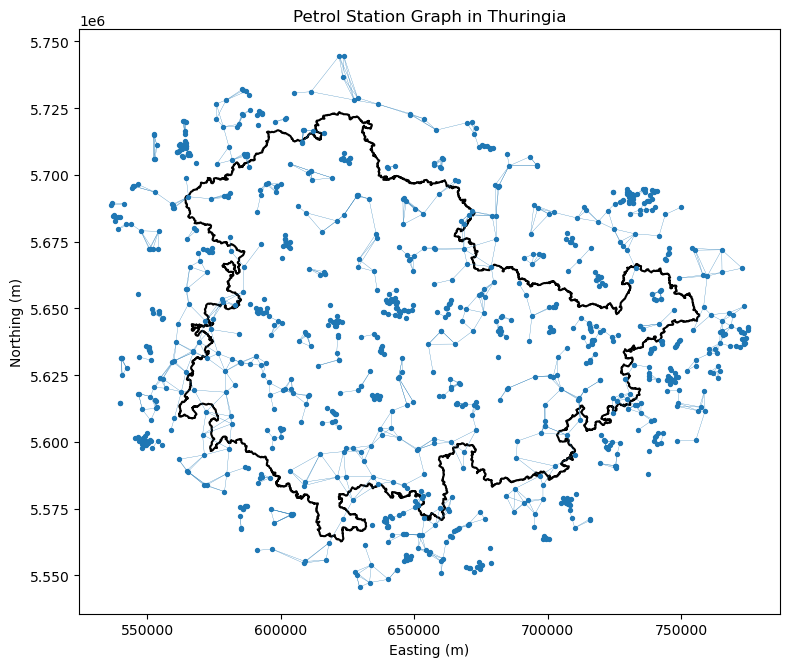

In [170]:
# Base data
data, meta = make_data_from_df(df)
coords = meta[[LAT_COL, LON_COL]].to_numpy(dtype=float)
edge_index = data.edge_index.detach().cpu().numpy()
mask_uniq = edge_index[0] < edge_index[1]
src, dst = edge_index[0][mask_uniq], edge_index[1][mask_uniq]

# GeoFrames: project Thuringia boundaries
gdf = gpd.read_file("/gpfs/scratch/qusta100/STGNN/Data/Shapes/thuringia.geojson").to_crs(epsg=25832)

# Points as GeoDataFrame
points_wgs84 = gpd.GeoSeries(gpd.points_from_xy(coords[:,1], coords[:,0]), crs=4326)
points = points_wgs84.to_crs(epsg=25832)

# Edges as LineStrings
from shapely.geometry import LineString
lines = gpd.GeoSeries(
    [LineString([points.iloc[i], points.iloc[j]]) for i, j in zip(src, dst)],
    crs=25832
)

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, linewidth=1.5, edgecolor="black", facecolor="none")
lines.plot(ax=ax, linewidth=0.2)
points.plot(ax=ax, markersize=8)

ax.set_title("Petrol Station Graph in Thuringia")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [171]:
# Calculating metrices

# 1. Number of Edges and Isolated Stations
res = region_graph_metrics(df, meta, data) 
print("Average Degree:", res["avg_degree"])
print("isolated Stations:", res["num_isolated"])

# 2. Min/Max/Mean of Neighbours
def edge_distance_stats_adaptive(lat_lon_deg: np.ndarray):
    edge_index, dists_km = build_radius_graph(
        lat_lon_deg, return_dists=True
    )
    return _edge_dist_stats(edge_index, dists_km)


stats2 = edge_distance_stats_adaptive(stations)
print(stats2)

Average Degree: 3.66
isolated Stations: 6
{'min_km': 0.708, 'max_km': 14.791, 'mean_km': 3.971, 'n_nodes_with_edges': 394}


## 3.3 Approach 3 (Limited Neighbours)

In [144]:
# =============================
# a) Updated Parameter
# =============================

NEIGHBOUR = 5

# =============================
# b) Updated Auxilary Functions
# =============================


def build_knn_graph(lat_lon_deg: np.ndarray, k: int = 5, return_dists: bool = False):
    lat_lon_rad = np.radians(lat_lon_deg)
    tree = BallTree(lat_lon_rad, metric="haversine")

    dist, ind = tree.query(lat_lon_rad, k=k + 1)  # +1 for Self
    src, dst, dists = [], [], []

    for i, (neigh, d) in enumerate(zip(ind, dist)):
        for j, dij in zip(neigh[1:], d[1:]):  # [1:] ignores i itself
            src.append(j)   # j -> i
            dst.append(i)
            dists.append(dij)

    edge_index = np.vstack([np.array(src), np.array(dst)])
    
    if return_dists:
        dists_km = np.array(dists) * 6371.0088  # Haversine in km
        return edge_index, dists_km
    
    return edge_index


def make_data_from_df(df: pd.DataFrame) -> tuple[Data, pd.DataFrame]:
    assert all(col in df.columns for col in [STATION_COL, LAT_COL, LON_COL, TARGET_COL]), (
        f"Expected columns are missing. Found: {df.columns.tolist()}"
    )

    stations = df[[STATION_COL, LAT_COL, LON_COL]].drop_duplicates().reset_index(drop=True)
    stations["node_id"] = np.arange(len(stations))

    # Edges over 5-km-Radius
    lat_lon = stations[[LAT_COL, LON_COL]].to_numpy(dtype=float)
    edge_index_np = build_knn_graph(lat_lon, k=NEIGHBOUR)

    # Labels: If there are multiple lines per station, take the average value (one timestamp -> doesn't matter)
    # QS: in this case I do only have one time stamp (no difference)
    target = df.groupby(STATION_COL, as_index=False)[TARGET_COL].mean() 

    # Join: Map labels to node_ids
    snap = stations[[STATION_COL, "node_id"]].merge(target, on=STATION_COL, how="left")

    y = torch.full((len(stations), 1), float("nan"))
    mask_have = ~snap[TARGET_COL].isna()
    y_vals = snap.loc[mask_have, TARGET_COL].astype(float).to_numpy()
    node_ids = snap.loc[mask_have, "node_id"].astype(int).to_numpy()
    y[node_ids, 0] = torch.tensor(y_vals, dtype=torch.float32)

    # No external features: dummy input + learnable embeddings in the model
    x = torch.ones((len(stations), 1), dtype=torch.float32)

    data = Data(
        x=x,
        edge_index=torch.tensor(edge_index_np, dtype=torch.long),
        y=y.squeeze(-1) #because vector is expected
    )

    # Split only via nodes with valid labels
    mask_th = df[[STATION_COL, "in_thuringia"]].drop_duplicates().set_index(STATION_COL)["in_thuringia"]
    snap = snap.join(mask_th, on=STATION_COL)
    avail_nodes = snap.loc[snap["in_thuringia"] == 1, "node_id"].to_numpy()
    
    train_nodes, temp_nodes = train_test_split(avail_nodes, test_size=VAL_SPLIT + TEST_SPLIT, random_state=SEED)
    rel = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)
    val_nodes, test_nodes = train_test_split(temp_nodes, test_size=rel, random_state=SEED)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.test_mask  = torch.zeros(data.num_nodes, dtype=torch.bool) # all false

    data.train_mask[torch.tensor(train_nodes)] = True
    data.val_mask[torch.tensor(val_nodes)] = True
    data.test_mask[torch.tensor(test_nodes)] = True

    meta = stations[[STATION_COL, LAT_COL, LON_COL, "node_id"]].copy()
    return data, meta

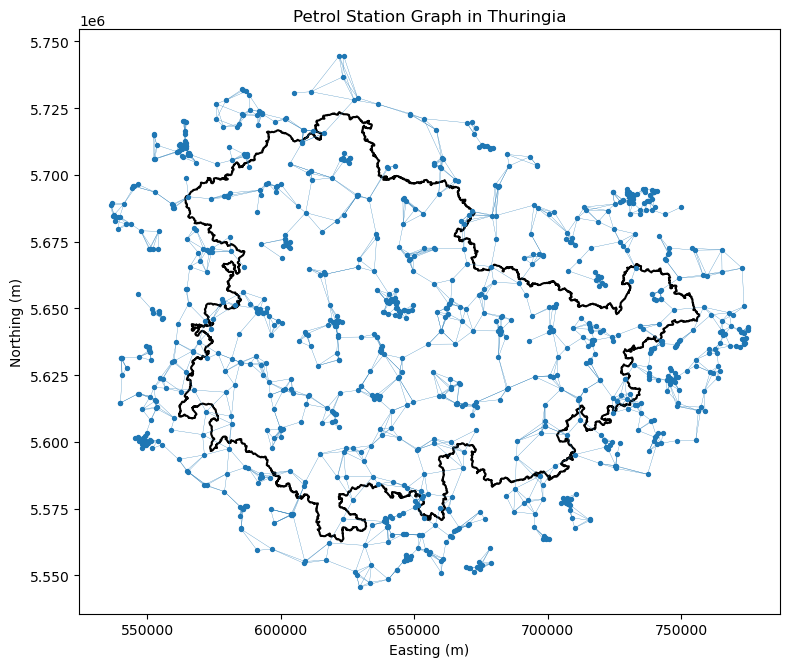

In [60]:
# Base data
data, meta = make_data_from_df(df)
coords = meta[[LAT_COL, LON_COL]].to_numpy(dtype=float)
edge_index = data.edge_index.detach().cpu().numpy()
mask_uniq = edge_index[0] < edge_index[1]
src, dst = edge_index[0][mask_uniq], edge_index[1][mask_uniq]

# GeoFrames: project Thuringia boundaries
gdf = gpd.read_file("/gpfs/scratch/qusta100/STGNN/Data/Shapes/thuringia.geojson").to_crs(epsg=25832)

# Points as GeoDataFrame
points_wgs84 = gpd.GeoSeries(gpd.points_from_xy(coords[:,1], coords[:,0]), crs=4326)
points = points_wgs84.to_crs(epsg=25832)

# Edges as LineStrings
from shapely.geometry import LineString
lines = gpd.GeoSeries(
    [LineString([points.iloc[i], points.iloc[j]]) for i, j in zip(src, dst)],
    crs=25832
)

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, linewidth=1.5, edgecolor="black", facecolor="none")
lines.plot(ax=ax, linewidth=0.2)
points.plot(ax=ax, markersize=8)

ax.set_title("Petrol Station Graph in Thuringia")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [61]:
# Calculating metrices

# 1. Number of Edges and Isolated Stations
res = region_graph_metrics(df, meta, data) 
print("Average Degree:", res["avg_degree"])
print("isolated Stations:", res["num_isolated"])

# 2. Min/Max/Mean of Neighbours
def edge_distance_stats_knn(lat_lon_deg: np.ndarray, k: int = 5):
    edge_index, dists_km = build_knn_graph(
        lat_lon_deg, k=k, return_dists=True
    )
    return _edge_dist_stats(edge_index, dists_km)

stats3 = edge_distance_stats_knn(stations, k=NEIGHBOUR)
print(stats3)

Average Degree: 5.0
isolated Stations: 0
{'min_km': 0.914, 'max_km': 15.29, 'mean_km': 4.959, 'n_nodes_with_edges': 401}


## 3.4 Approach 4 (Limited Neighbours with distance brake)

In [172]:
# =============================
# a) Updated Parameter
# =============================

RADIUS_KM = 10
NEIGHBOUR = 5

# =============================
# b) Updated Auxilary Functions
# =============================


def build_knn_graph(
    lat_lon_deg: np.ndarray,
    k: int = 5,
    return_dists: bool = False,
    RADIUS_KM: Optional[float] = None
) -> np.ndarray | Tuple[np.ndarray, np.ndarray]:
    
    lat_lon_rad = np.radians(lat_lon_deg)
    tree = BallTree(lat_lon_rad, metric="haversine")

    dist_rad, ind = tree.query(lat_lon_rad, k=k + 1)

    src, dst, dists_km = [], [], []
    radius_rad = km_to_radians(RADIUS_KM) if RADIUS_KM is not None else None

    for i, (neigh_idx, neigh_dist_rad) in enumerate(zip(ind, dist_rad)):
        for j, dij_rad in zip(neigh_idx[1:], neigh_dist_rad[1:]):
            if radius_rad is not None and dij_rad > radius_rad:
                continue

            dij_km = dij_rad * 6371.0088  # Conversion for output
            src.append(j)
            dst.append(i)
            dists_km.append(dij_km)


    edge_index = np.vstack([np.array(src, dtype=int), np.array(dst, dtype=int)])

    if return_dists:
        return edge_index, np.asarray(dists_km, dtype=float)
    return edge_index


def make_data_from_df(df: pd.DataFrame) -> tuple[Data, pd.DataFrame]:
    assert all(col in df.columns for col in [STATION_COL, LAT_COL, LON_COL, TARGET_COL]), (
        f"Expected columns are missing. Found: {df.columns.tolist()}"
    )

    stations = df[[STATION_COL, LAT_COL, LON_COL]].drop_duplicates().reset_index(drop=True)
    stations["node_id"] = np.arange(len(stations))

    # Edges over 5-km-Radius
    lat_lon = stations[[LAT_COL, LON_COL]].to_numpy(dtype=float)
    edge_index_np = build_knn_graph(lat_lon, k=NEIGHBOUR, RADIUS_KM=RADIUS_KM)


    # Labels: If there are multiple lines per station, take the average value (one timestamp -> doesn't matter)
    # QS: in this case I do only have one time stamp (no difference)
    target = df.groupby(STATION_COL, as_index=False)[TARGET_COL].mean() 

    # Join: Map labels to node_ids
    snap = stations[[STATION_COL, "node_id"]].merge(target, on=STATION_COL, how="left")

    y = torch.full((len(stations), 1), float("nan"))
    mask_have = ~snap[TARGET_COL].isna()
    y_vals = snap.loc[mask_have, TARGET_COL].astype(float).to_numpy()
    node_ids = snap.loc[mask_have, "node_id"].astype(int).to_numpy()
    y[node_ids, 0] = torch.tensor(y_vals, dtype=torch.float32)

    # No external features: dummy input + learnable embeddings in the model
    x = torch.ones((len(stations), 1), dtype=torch.float32)

    data = Data(
        x=x,
        edge_index=torch.tensor(edge_index_np, dtype=torch.long),
        y=y.squeeze(-1) #because vector is expected
    )

    # Split only via nodes with valid labels
    mask_th = df[[STATION_COL, "in_thuringia"]].drop_duplicates().set_index(STATION_COL)["in_thuringia"]
    snap = snap.join(mask_th, on=STATION_COL)
    avail_nodes = snap.loc[snap["in_thuringia"] == 1, "node_id"].to_numpy()
    
    train_nodes, temp_nodes = train_test_split(avail_nodes, test_size=VAL_SPLIT + TEST_SPLIT, random_state=SEED)
    rel = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)
    val_nodes, test_nodes = train_test_split(temp_nodes, test_size=rel, random_state=SEED)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool) # all false
    data.test_mask  = torch.zeros(data.num_nodes, dtype=torch.bool) # all false

    data.train_mask[torch.tensor(train_nodes)] = True
    data.val_mask[torch.tensor(val_nodes)] = True
    data.test_mask[torch.tensor(test_nodes)] = True

    meta = stations[[STATION_COL, LAT_COL, LON_COL, "node_id"]].copy()
    return data, meta

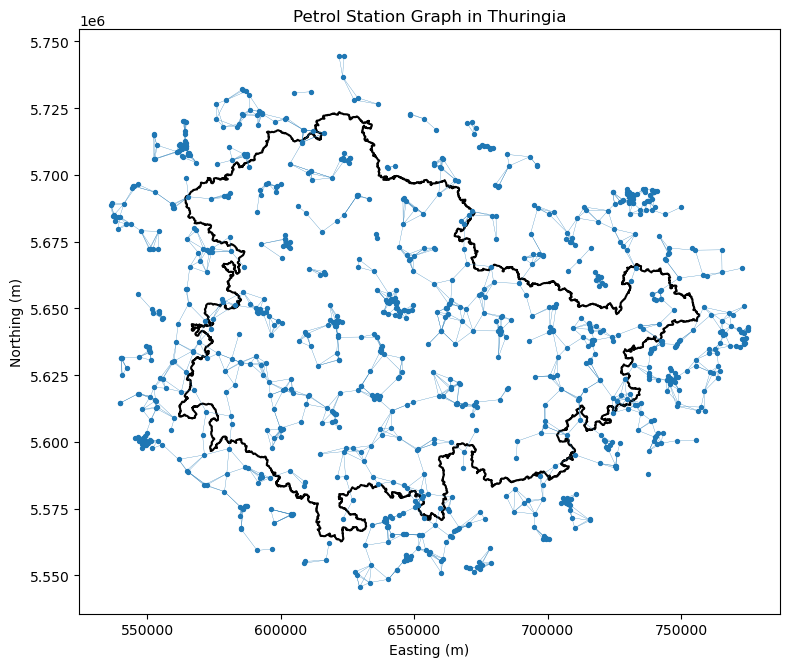

In [173]:
# Base data
data, meta = make_data_from_df(df)
coords = meta[[LAT_COL, LON_COL]].to_numpy(dtype=float)
edge_index = data.edge_index.detach().cpu().numpy()
mask_uniq = edge_index[0] < edge_index[1]
src, dst = edge_index[0][mask_uniq], edge_index[1][mask_uniq]

# GeoFrames: project Thuringia boundaries
gdf = gpd.read_file("/gpfs/scratch/qusta100/STGNN/Data/Shapes/thuringia.geojson").to_crs(epsg=25832)

# Points as GeoDataFrame
points_wgs84 = gpd.GeoSeries(gpd.points_from_xy(coords[:,1], coords[:,0]), crs=4326)
points = points_wgs84.to_crs(epsg=25832)

# Edges as LineStrings
from shapely.geometry import LineString
lines = gpd.GeoSeries(
    [LineString([points.iloc[i], points.iloc[j]]) for i, j in zip(src, dst)],
    crs=25832
)

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, linewidth=1.5, edgecolor="black", facecolor="none")
lines.plot(ax=ax, linewidth=0.2)
points.plot(ax=ax, markersize=8)

ax.set_title("Petrol Station Graph in Thuringia")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [174]:
# Calculating metrices

# 1. Number of Edges and Isolated Stations
res = region_graph_metrics(df, meta, data) 
print("Average Degree:", res["avg_degree"])
print("isolated Stations:", res["num_isolated"])


# 2. Min/Max/Mean of Neighbours
def edge_distance_stats_knn_radius(
    lat_lon_deg: np.ndarray, k: int = 5, radius_km: float | None = None
):
    edge_index, dists_km = build_knn_graph(
        lat_lon_deg, k=k, return_dists=True, RADIUS_KM=radius_km
    )
    return _edge_dist_stats(edge_index, dists_km)

stats4 = edge_distance_stats_knn_radius(stations, k=NEIGHBOUR, radius_km=RADIUS_KM)
print(stats4)

Average Degree: 4.65
isolated Stations: 0
{'min_km': 0.914, 'max_km': 9.79, 'mean_km': 4.233, 'n_nodes_with_edges': 396}
